# Libraries

In [1]:
from __future__ import division, print_function

import os
import numpy as np
from numpy.polynomial.polynomial import polyval
import scipy.io as sio
import matplotlib.pyplot as plt
import math
from math import pi

from lib import *

from IPython.display import clear_output
%matplotlib inline

# Directories

In [2]:
# Data files
name_folder = 'matlab2'
name_file = 'sol30_gain20'

name_folder_ex = 'export'
name_file_ex = 'sol30_gain20'

# Directory
dir_main = os.getcwd()
dir_mat = os.path.join(dir_main, 'data', name_folder, name_file)
dir_export = os.path.join(dir_main, 'data', name_folder_ex, name_file_ex)

# Import using Scipy
dict_mat = sio.loadmat(dir_mat)

# Import data

In [3]:
# Import using Scipy
dict_mat = sio.loadmat(dir_mat)

sol = {}
sol['t'] = np.reshape(dict_mat['t'], -1)
sol['y'] = dict_mat['y']
sol['yp'] = dict_mat['yp']

sol['gain'] = dict_mat['gain'][0,0]

# Process data

In [4]:
# Asymptotic percentage
asy = 0.1

# Compute the global frequency:
arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
Omega = np.sum(arr_omega) / arr_omega.size

# Get array of asymptotic phases:
arr_lin = Omega*sol['t']
arr_lin = arr_lin[:,None]

arr_diff = sol['y'] - arr_lin
asy_phases = asylib.weight_avg(sol['t'], arr_diff, asy)
mod_asy_phases = np.mod(asy_phases, 2*pi)

# Compute asymptotic phase variance
asy_diffs = asy_phases[:,None] - asy_phases
sigma2 = np.var(asy_diffs)

# Plot results

## Arrays over time

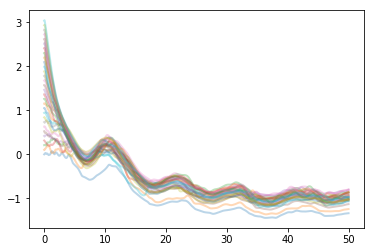

In [5]:
fig, ax = plt.subplots(1,1)

# Figure options
pltopts = {'linewidth': 2.0,
           'alpha': 0.3,
          }
ind_s = int(sol['t'].size*(1 - asy))
ax.plot(sol['t'], arr_diff, **pltopts)
ax.plot([],[])

# Asymptotic distribution and fit

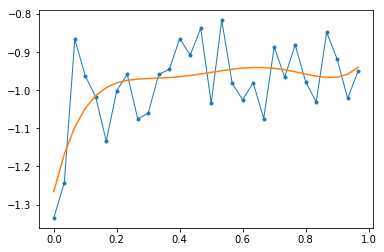

In [6]:
fig, ax = plt.subplots(1,1)

# Figure options
pltopts = {'linestyle': '-',
           'linewidth': 1.0,
           'marker': '.',
          }

# Arrays
# asy_phases_sort = asy_phases # np.sort(asy_phases)
asy_inds = np.arange(asy_phases.size)/asy_phases.size

# Line fit
degree = 5
b = np.polyfit(asy_inds, asy_phases, degree)
b = np.flip(b, axis=-1)
ax.plot(asy_inds, asy_phases, **pltopts)
ax.plot(asy_inds, polyval(asy_inds, b))

# Use asymptotic values to find theoretical roots

In [7]:
# Parameters
param = {'g': dict_mat['g'][0,0],
        'omega0': dict_mat['omega0'][0,0],
        'a' : 1.0,
        'T' : dict_mat['T'][0,0],
        'gain': dict_mat['gain'][0,0],
        'N': dict_mat['N'][0,0]
        }

# Approximation parameters
N_x = param['N']
N_tau = N_x**2

# Earlier numeric asymptotic values
phi_fun = lambda X: polyval(X, b)
sigma = np.sqrt(sigma2)

# Model parameters
w0 = param['omega0']
g = param['g']
a = param['a']
T = param['T']

# Root finding methods
fun = lambda u: w0 + g*a*funlib.R_sum(u, N_tau, N_x, param, phi_fun) - u
Omega1 = rootlib.find_root(fun, w0, w0-g, w0+g, steps=20)

# Analytic solution without gain
fun2 = lambda u: w0 + g*a*(np.cos(2*T*u)-1)/(2*T*u) - u
Omega2 = rootlib.find_root(fun2, w0, w0-g, w0+g, steps=20)

# Approximate solution using Gaussian distribution
fun3 = lambda u: w0 + g*a*funlib.R_sum_gauss(u, N_tau, N_x, param, sigma) - u
Omega3 = rootlib.find_root(fun3, w0, w0-g, w0+g, steps=20)

# Print results
print('Numeric: {0}'.format(Omega))
print('Polynomial: {0}'.format(Omega1))
print('Gaussian: {0}'.format(Omega3))

Numeric: 0.9316068335806486
Polynomial: (0.8079523748521369, True)
Gaussian: (0.8702509964752704, True)


# Root plot

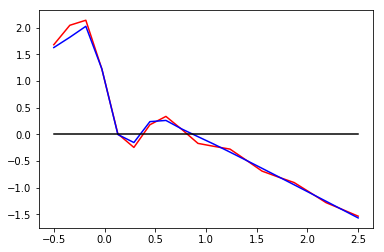

In [8]:
fig, ax = plt.subplots(1,1)

x_arr = np.linspace(w0-g, w0+g, num=20)
y_arr = np.array([fun(x) for x in x_arr])
y_arr3 = np.array([fun3(x) for x in x_arr])

ax.plot(x_arr, y_arr, color='red')
ax.plot(x_arr, y_arr3, color='blue')
ax.plot(x_arr, np.zeros(x_arr.size), color='black')

# Export results

In [9]:
# All relevant data
dict_mat2 = {}

dict_mat2['phi'] = asy_phases # Asymptotic phases
dict_mat2['Omega'] = Omega # Asymptotic frequency
dict_mat2['inds'] = asy_inds # Asymptotic indices
dict_mat2['tau0'] = dict_mat['tau0'] # Initial delays
dict_mat2['b'] = b

# Relevant parameters
for key in param.keys():
    dict_mat2[key] = param[key]

# Save data
sio.savemat(dir_export, dict_mat2)